In [897]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [898]:
import urllib  # the lib that handles the url stuff

data = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names') # it's a file like object and works just like a file
for line in data: # files are iterable
    print(line)

b'1. Title: Auto-Mpg Data\n'
b'\n'
b'2. Sources:\n'
b'   (a) Origin:  This dataset was taken from the StatLib library which is\n'
b'                maintained at Carnegie Mellon University. The dataset was \n'
b'                used in the 1983 American Statistical Association Exposition.\n'
b'   (c) Date: July 7, 1993\n'
b'\n'
b'3. Past Usage:\n'
b'    -  See 2b (above)\n'
b'    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.\n'
b'       In Proceedings on the Tenth International Conference of Machine \n'
b'       Learning, 236-243, University of Massachusetts, Amherst. Morgan\n'
b'       Kaufmann.\n'
b'\n'
b'4. Relevant Information:\n'
b'\n'
b'   This dataset is a slightly modified version of the dataset provided in\n'
b'   the StatLib library.  In line with the use by Ross Quinlan (1993) in\n'
b'   predicting the attribute "mpg", 8 of the original instances were removed \n'
b'   because they had unknown values for the "mpg" attribute.  The original \n'
b'   d

In [899]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', delim_whitespace=True, names=column_names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# Data cleaning

In [900]:
df = df.replace('?', np.nan)
df = df.dropna()
df['horsepower'] = df['horsepower'].astype(float)
df['origin'] = df['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Data visualisation

In [901]:
independant_var = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']

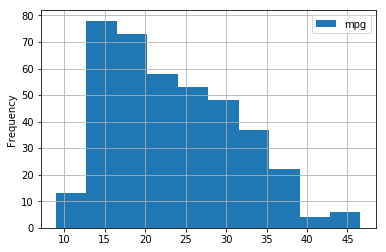

In [902]:
df.plot(kind='hist', y='mpg', grid=True)

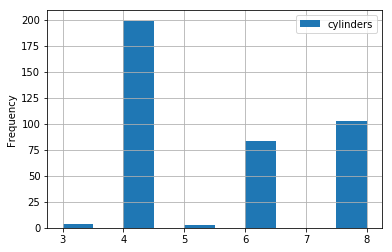

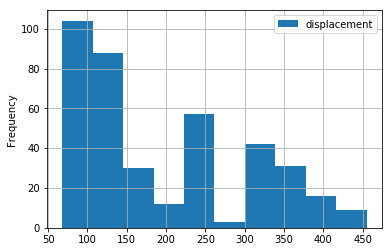

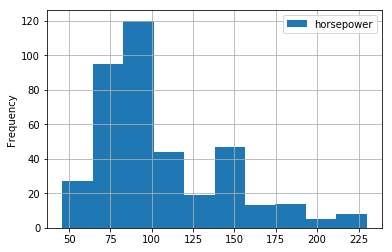

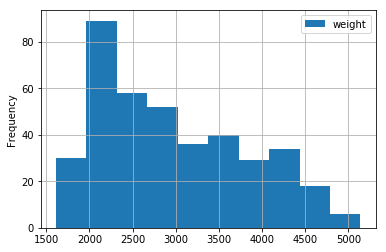

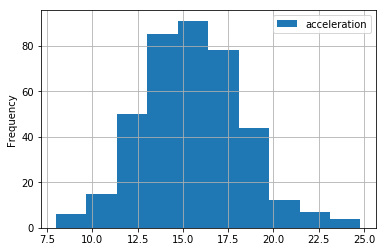

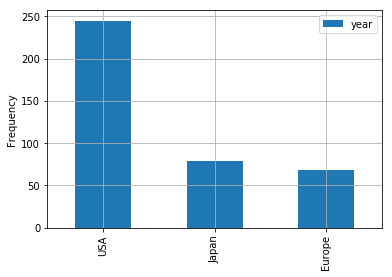

In [903]:
for param in independant_var:
    try:
        df.plot(kind='hist', y=param, grid=True)
    except:
        df[param].value_counts().plot(kind='bar', grid=True)

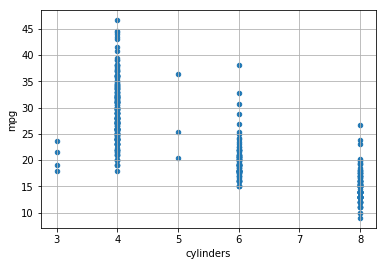

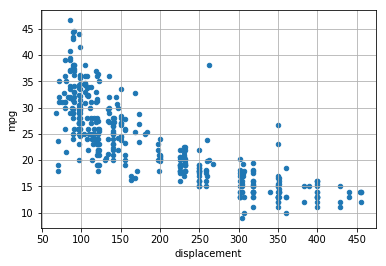

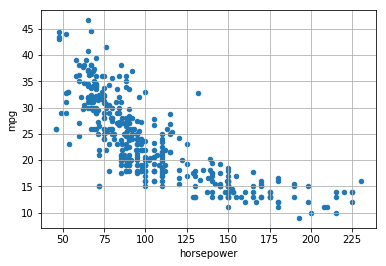

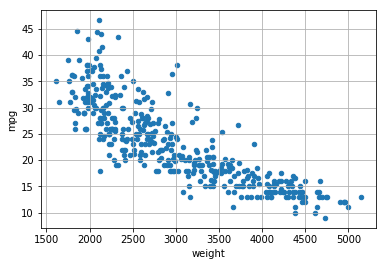

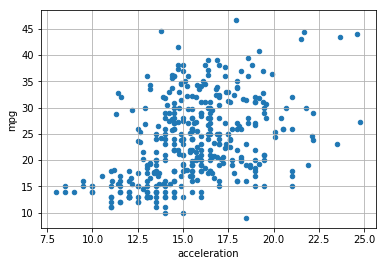

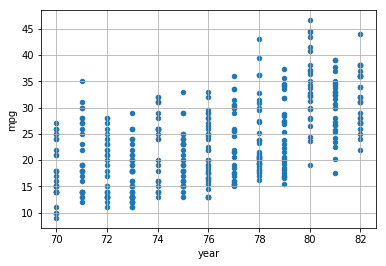

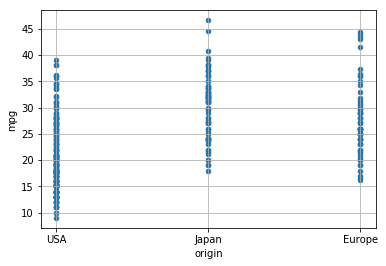

In [904]:
for param in independant_var:
    df.plot(kind='scatter', x=param, y='mpg', grid=True)

# Model
Aim is to model mpg (miles per gallon) from information contained in the dataset

## Scaling
Features with main importance are kept and dataset is split in training and testing sets.

In [905]:
from sklearn.model_selection import train_test_split

df = pd.get_dummies(df, prefix='', prefix_sep='')

main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'USA', 'Europe', 'Japan']

from sklearn import preprocessing

X_scaler = preprocessing.StandardScaler()
X_train = X_scaler.fit_transform(df[main_independant_var])
y_train = df['mpg']

# Tensorflow

In [906]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

print(tf.__version__)

2.2.0


In [907]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [908]:
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 100

In [909]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(units=128,
                     activation="elu",
                     kernel_initializer=initializers.he_normal(),
                     bias_initializer=initializers.Zeros(),
                     input_shape=[len(main_independant_var)],
                     name="layer1"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(units=64,
                     activation="elu",
                     kernel_initializer=initializers.he_normal(),
                     bias_initializer=initializers.Zeros(),
                     name="layer2"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(units=1,
                     kernel_initializer=initializers.he_normal(),
                     bias_initializer=initializers.Zeros(),
                     name="layer3",
                     activity_regularizer=regularizers.L1L2()
                    ),
    ]
)

In [910]:
model.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 128)               1280      
_________________________________________________________________
batch_normalization_149 (Bat (None, 128)               512       
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)               0         
_________________________________________________________________
layer2 (Dense)               (None, 64)                8256      
_________________________________________________________________
batch_normalization_150 (Bat (None, 64)                256       
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
layer3 (Dense)               (None, 1)               

In [911]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
epoch_dots = tfdocs.modeling.EpochDots(report_every=10, dot_every=1)

In [912]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True),  # Optimizer
    # Loss function to minimize
    loss='mse',
    # List of metrics to monitor
    metrics=['mse', 'mae'],
)

In [913]:
print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_split=0.2,
    callbacks=[early_stopping, epoch_dots],
    verbose=0
)

Fit model on training data

Epoch: 0, loss:478.6045,  mae:21.1330,  mse:478.6045,  val_loss:764.7675,  val_mae:27.2685,  val_mse:764.7675,  
..........
Epoch: 10, loss:24.2189,  mae:3.8484,  mse:24.2189,  val_loss:22.6210,  val_mae:3.8880,  val_mse:22.6210,  
..........
Epoch: 20, loss:18.4300,  mae:3.3763,  mse:18.4300,  val_loss:19.1528,  val_mae:3.4238,  val_mse:19.1528,  
..........
Epoch: 30, loss:15.5330,  mae:3.0245,  mse:15.5330,  val_loss:17.5020,  val_mae:3.0901,  val_mse:17.5020,  
..........

(0, 20)

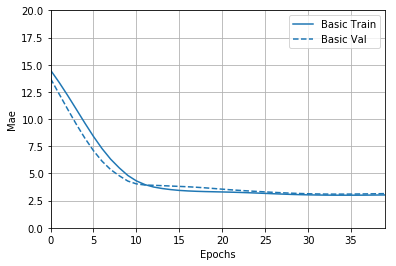

In [914]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 20])

In [915]:
df['MPG_pred'] = model(X_scaler.transform(df[main_independant_var]), training=False).numpy()
df['MPG_error'] = df['MPG_pred'] - df['mpg']

In [916]:
from sklearn.metrics import mean_squared_error, r2_score
print(
    'scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(df['MPG_pred'], df['mpg']),
           r2_score(df['MPG_pred'], df['mpg'])
          )
)

scores
mse=9.03
r2=0.83



/Users/thomas/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


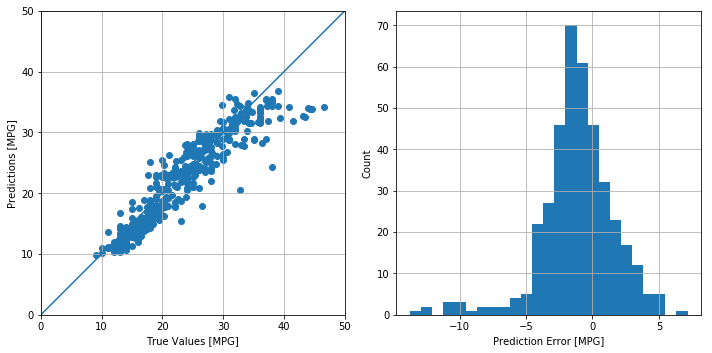

In [917]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].scatter(df['mpg'], df['MPG_pred'])
ax[0].set_xlabel('True Values [MPG]')
ax[0].set_ylabel('Predictions [MPG]')
lims = [0, 50]
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[0].plot(lims, lims)
ax[0].set_aspect('equal')
ax[0].grid('on')

ax[1].hist(df['MPG_error'], bins = 25)
ax[1].set_xlabel("Prediction Error [MPG]")
ax[1].set_ylabel("Count")
#ax[1].set_aspect('equal')
ax[1].grid('on')

plt.tight_layout()

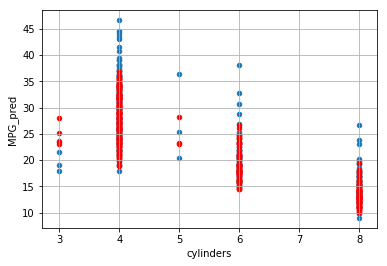

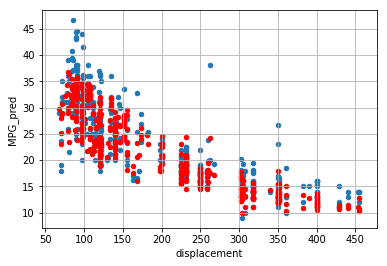

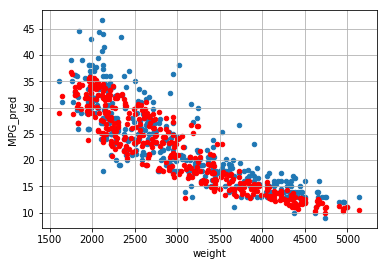

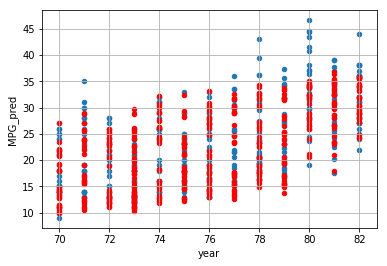

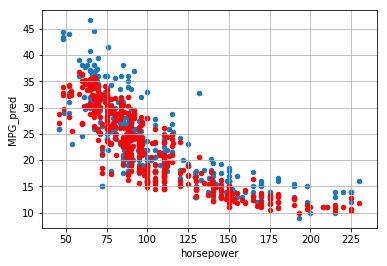

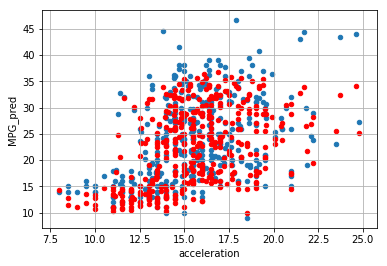

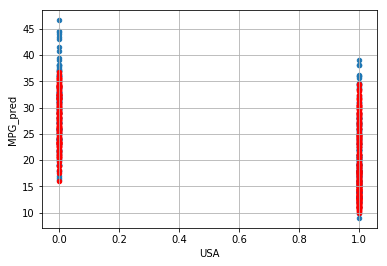

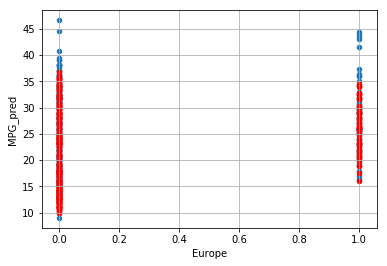

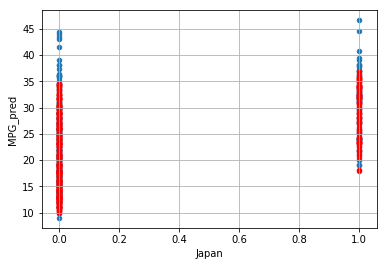

In [918]:
for param in main_independant_var:
    ax = df.plot(kind='scatter', x=param, y='mpg', grid=True)
    df.plot(kind='scatter', x=param, y='MPG_pred', grid=True, ax=ax, c='r')

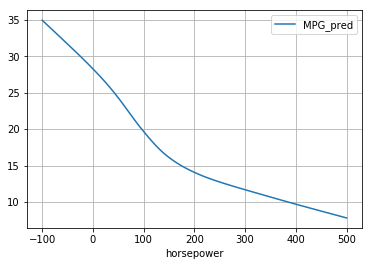

In [923]:
df_tmp = pd.DataFrame()
main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'USA', 'Europe', 'Japan']


df_tmp['cylinders'] = [6]*100#np.linspace(0, 10, 100)#
df_tmp['displacement'] = 250#np.linspace(0, 500, 100)#200
df_tmp['weight'] = 3000#np.linspace(0, 10000, 100)#[5000]*100
df_tmp['year'] = 76#[70, 80]*50
df_tmp['horsepower'] = np.linspace(-100, 500, 100)
df_tmp['acceleration'] = 15#np.linspace(0, 30, 100)#20
df_tmp['USA'] = 1
df_tmp['Europe'] = 0
df_tmp['Japan'] = 0

df_tmp['MPG_pred'] = model(X_scaler.transform(df_tmp[main_independant_var]), training=False).numpy()

ax = df_tmp.plot(kind='line', x='horsepower', y='MPG_pred', grid=True)